## Import Libraries :

In [106]:
import pandas as pd
import chardet
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression ,Ridge,Lasso,LinearRegression
from sklearn.metrics import accuracy_score,r2_score
from sklearn.model_selection import  GridSearchCV, cross_val_score,cross_validate,train_test_split
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Upload file :

In [72]:
uploaded = files.upload()

with open(list(uploaded.keys())[0], 'rb') as f:
    result = chardet.detect(f.read())

# Read the file using the detected encoding
dataset = pd.read_csv(list(uploaded.keys())[0], encoding=result['encoding'])

Saving Walmart_Store_sales.csv to Walmart_Store_sales (2).csv


## Part 1 : EDA and all preprocessings

In [74]:
print("Display of dataset: ")
display(dataset.head())
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

☢️ Our focus is on Weekly_Sales, and it's important to exclude any data points where this value is missing, as they could potentially skew our analysis.

In [75]:
dataset = dataset.dropna(axis=0, subset=['Weekly_Sales'])
print("New percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

New percentage of missing values: 


Store            0.000000
Date            13.235294
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature     11.029412
Fuel_Price       8.823529
CPI              8.088235
Unemployment    10.294118
dtype: float64

* add a new column to a dataset that contains the week number of the year for each date

In [76]:
dataset['Date'] = pd.to_datetime(dataset['Date'], errors='ignore')
dataset['weekofyear'] = dataset['Date'].dt.isocalendar().week

<ipython-input-76-4345dc48bc99>:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset['Date'] = pd.to_datetime(dataset['Date'], errors='ignore')


To ensure the accuracy and reliability of our analysis, we will remove any data points that contain invalid values or outliers. In this project, we will consider any numeric feature that falls outside of the range of [mean - 3 standard deviations, mean + 3 standard deviations] to be an outlier.

In [77]:
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
results = []

for feature in features:
    low = dataset[feature].mean() - 3 * dataset[feature].std()
    high = dataset[feature].mean() + 3 * dataset[feature].std()
    outliers = dataset.loc[(dataset[feature] <= low) | (dataset[feature] >= high)]
    num_outliers = outliers.shape[0]
    dataset = dataset.drop(outliers.index)
    results.append([feature, num_outliers])

results_df = pd.DataFrame(results, columns=['Feature', 'Number of Outliers'])
print(results_df)


        Feature  Number of Outliers
0   Temperature                   0
1    Fuel_Price                   0
2           CPI                   0
3  Unemployment                   5


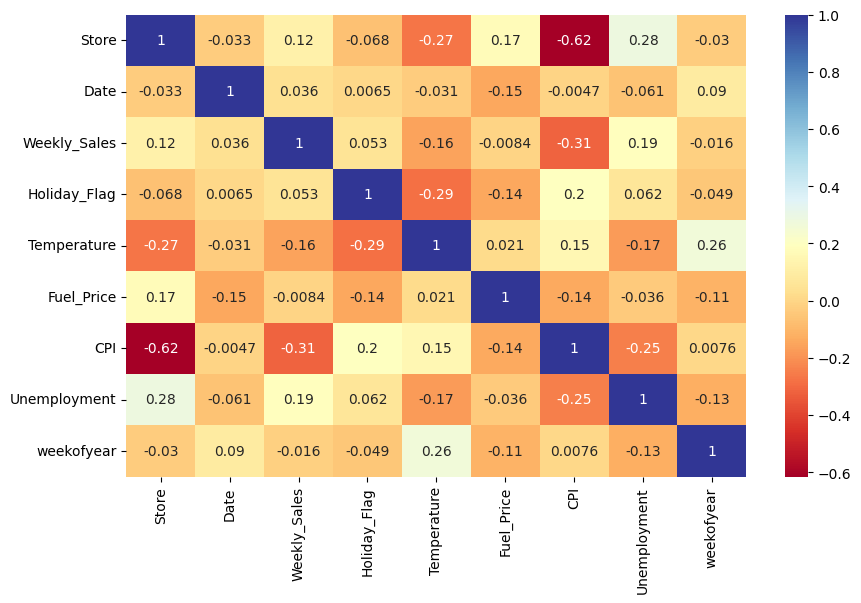

In [78]:
#heatmap
plt.figure(figsize=(10,6))
sns.heatmap(dataset.corr(),cmap='RdYlBu',annot=True)
plt.show()

💵 Explanation/commentary :

The analysis of the correlation between various features and weekly sales revealed that the Consumer Price Index (CPI) has the highest negative correlation with weekly sales, indicating that as prices rise, sales tend to decrease. This could be due to a decrease in disposable income for consumers. On the other hand, unemployment has the highest positive correlation with weekly sales, suggesting that as more people are out of work, sales tend to increase. This could be because Walmart is a low-cost store, and people who are out of work may be more likely to shop there in order to save money.

### Preprossesing :

The code prepares the data for a machine learning model by removing the 'Date' and 'Weekly_Sales' columns, as they are non-numeric and the target variable, respectively, and then splitting the data into feature variables (X) and target variable (Y) for training and testing the model.

In [79]:
to_drop = ['Date', 'Weekly_Sales']
features = [c for c in dataset.columns if c not in to_drop]
target_name = 'Weekly_Sales'

X = dataset.loc[:, features]
Y = dataset.loc[:,target_name]
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [80]:
numeric_indices =[2,3,4,5,6]
categorical_indices = [0,1]

numeric_transformer = Pipeline(
    steps=[
        ("num_imputer", SimpleImputer(strategy="mean")),
        ("num_scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("...Done")

...Done
...Done


In [81]:
encoder = preprocessor.transformers_[0][1].named_steps['encoder']
cat_feat_names = ['Store_' + str(i) for i in encoder.categories_[0]] + ['Holiday_Flag_' + str(i) for i in encoder.categories_[1]]
feature_name=cat_feat_names+['Temperature','Fuel_Price','CPI','Unemployment','weekofyear']

## Part 2 [Baseline] : linear regression

Evaluate the performance of a linear regression model on a training dataset using cross-validation:

In [100]:
reg = LinearRegression()
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(reg, X_train, Y_train, cv=5, scoring=scoring)

print('The cross-validated R2-score is : ', round(scores['test_r2'].mean(),4))
print('The mean squared error is : ', round(-scores['test_neg_mean_squared_error'].mean(),4))
print('The standard deviation of R2-score is : ', round(scores['test_r2'].std(),4))
print('The standard deviation of mean squared error is : ', round(scores['test_neg_mean_squared_error'].std(),4))

The cross-validated R2-score is :  0.9466
The mean squared error is :  21750101652.4395
The standard deviation of R2-score is :  0.0159
The standard deviation of mean squared error is :  6207937816.0618


* The cross-validated R-squared score is 0.947, which indicates that the model explains approximately 94.7% of the variance in the target variable. This is a relatively high score, suggesting that the model fits the data well.

* The mean squared error is 21.75 billion, which is a large value. This indicates that the model has a relatively high level of error when making predictions.
* The standard deviation of the R-squared score is 0.016, which is a relatively low value. This indicates that the model's performance is consistent across different folds of cross-validation.
* The standard deviation of the mean squared error is 6.21 billion, which is a relatively high value. This indicates that the model's performance is less consistent across different folds of cross-validation, and that there may be some variability in the model's predictions.


Overall, the results suggest that the linear regression model fits the data well, but that there is still room for improvement in terms of reducing the level of error in the model's predictions. Regularized regression models, such as Ridge or Lasso regression, may be able to improve the model's performance by reducing overfitting and improving the stability of the model's predictions.

* Train the linreg model :

In [89]:
reg.fit(X_train, Y_train)
print('...Done')

...Done


* Predictions :

In [91]:
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

* Evaluate the performance of a trained regression model on both the training set and the test set :

In [98]:
print("R2 Train set: ", round(r2_score(Y_train, Y_train_pred),4))
print("R2 Test set: ", round(r2_score(Y_test, Y_test_pred),4))

R2 Train set:  0.9703
R2 Test set:  0.9319


The R-squared score on the training set is higher than the R-squared score on the test set, which suggests that the model **may be overfitting** the training data.

Overfitting occurs when a model is too complex and fits the training data too closely.

## Part 3: Overfitting countermeasures

 Fight overfitting by training multiple regularized regression models with different values of the regularization parameter and comparing their performance on the validation set.

In [104]:
def train_and_evaluate_models(X_train, Y_train, alpha_values):
    models = {}
    for alpha in alpha_values:
        ridge_reg = Ridge(alpha=alpha)
        ridge_reg.fit(X_train, Y_train)
        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(X_train, Y_train)
        models[f'lasso_reg_alpha_{alpha}'] = lasso_reg

    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X_train, Y_train, cv=5)
        results[name] = {'mean_score': scores.mean(), 'std_score': scores.std()}

    return models, results

alpha_values = [0.01, 100]
models, results = train_and_evaluate_models(X_train, Y_train, alpha_values)
for name, result in results.items():
    print(f'{name}: mean_score={result["mean_score"]:.3f}, std_score={result["std_score"]:.3f}')


ridge_reg_alpha_0.01: mean_score=0.946, std_score=0.016
lasso_reg_alpha_0.01: mean_score=0.947, std_score=0.016
ridge_reg_alpha_100: mean_score=0.027, std_score=0.120
lasso_reg_alpha_100: mean_score=0.947, std_score=0.017


We can see that the Ridge regression model with alpha=0.01 and the Lasso regression model with alpha=0.01 have similar mean scores of around 0.946 and 0.947, respectively. These scores are relatively high, indicating that these models fit the data well. The standard deviation scores for both models are also relatively low, indicating that the models' performance is consistent across different folds of cross-validation.

On the other hand, the Ridge regression model with alpha=100 has a much lower mean score of 0.027, which suggests that this model is underfitting the data. The standard deviation score for this model is also higher than for the other models, indicating that the model's performance is less consistent across different folds of cross-validation.

The Lasso regression model with alpha=100 has a mean score of 0.947, which is similar to the scores of the other models. However, the standard deviation score for this model is slightly higher than for the Lasso regression model with alpha=0.01. This suggests that the Lasso regression model with alpha=100 may be slightly less stable than the model with alpha=0.01, but it still fits the data well.

Overall, the results suggest that the Ridge regression model with alpha=0.01 and the Lasso regression model with alpha=0.01 are the best-performing models, as they have the highest mean scores and the lowest standard deviation scores. The Ridge regression model with alpha=100 is underfitting the data, while the Lasso regression model with alpha=100 is slightly less stable than the model with alpha=0.01, but it still fits the data well.

* Perform hyperparameter tuning for a Lasso regression model (Grid search cross-validation):

In [105]:
params = {'alpha': np.arange(0, 1000, 100)}
lasso = Lasso()
grid = GridSearchCV(lasso, params, cv = 10, verbose = 0)
grid_fit = grid.fit(X_train, Y_train)

print("Best value for alpha : ", grid_fit.best_params_)
print('Train score for the best model : ', grid_fit.best_estimator_.score(X_train,Y_train))
print('Test score for the best model : ', grid_fit.best_estimator_.score(X_test,Y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 571318788054.4636, tolerance: 4063733989.6724744
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

Optimal value for alpha :  {'alpha': 500}
Train score for the best model :  0.9696927964745765
Test score for the best model :  0.9410300851334124


The difference between the R-squared scores on the training and test data is not too large, which suggests that the model is not overfitting the training data.